In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from scipy.stats import skew
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

/Users/mac/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from last lab
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso




# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best =gs   #gs.best_estimator_
    return best


# def cv_optimize_ridge(X, y, n_folds=4):
#     clf = Ridge()
#     parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
#     #the scoring parameter below is the default one in ridge, but you can use a different one
#     #in the cross-validation phase if you want.
#     gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
#     gs.fit(X, y)
#     return gs


In [3]:
df=pd.read_csv("train.csv",sep=',')
print df.shape
df.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data cleaning & feature selection

There are in general two reasons why feature selection is used:
1. Reducing the number of features, to reduce overfitting and improve the generalization of models.
2. To gain a better understanding of the features and their relationship to the response variables.

These two goals are often at odds with each other and thus require different approaches: depending on the data at hand a feature selection method that is good for goal (1) isn’t necessarily good for goal (2) and vice versa. What seems to happen often though is that people use their favourite method (or whatever is most conveniently accessible from their tool of choice) indiscriminately, especially methods more suitable for (1) for achieving (2).



## Univariate selection

Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable. These methods are simple to run and understand and are in general particularly good for gaining a better understanding of data (but not necessarily for optimizing the feature set for better generalization). There are lot of different options for univariate selection.



### 1. Feature selection using correlation (pearson)

In [53]:
# we are going to take only numerical float and int for linear regression
g = df.columns.to_series().groupby(df.dtypes).groups
g

{dtype('int64'): ['Id',
  'MSSubClass',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold',
  'SalePrice'],
 dtype('float64'): ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'],
 dtype('O'): ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure

In [5]:
# numerical are selected
dfc=df.select_dtypes(exclude=['O'])
dfc.head()
 

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [11]:
# find and replace nan values
index=(dfc.isnull().sum() !=0)
dfc.isnull().sum()[index]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [12]:
corr=dfc.corr()
corr6=corr[corr.SalePrice > 0.60][["TotalBsmtSF", "1stFlrSF","GrLivArea","GarageArea","SalePrice"]]
corr6
#useful corr variables:
#TotalBsmtSF
#1stFlrSF
#GrLivArea
#GarageArea

,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
OverallQual,0.537808,0.476224,0.593007,0.562022,0.790982
TotalBsmtSF,1.000000,0.819530,0.454868,0.486665,0.613581
1stFlrSF,0.819530,1.000000,0.566024,0.489782,0.605852
GrLivArea,0.454868,0.566024,1.000000,0.468997,0.708624
GarageCars,0.434585,0.439317,0.467247,0.882475,0.640409
GarageArea,0.486665,0.489782,0.468997,1.000000,0.623431
SalePrice,0.613581,0.605852,0.708624,0.623431,1.000000


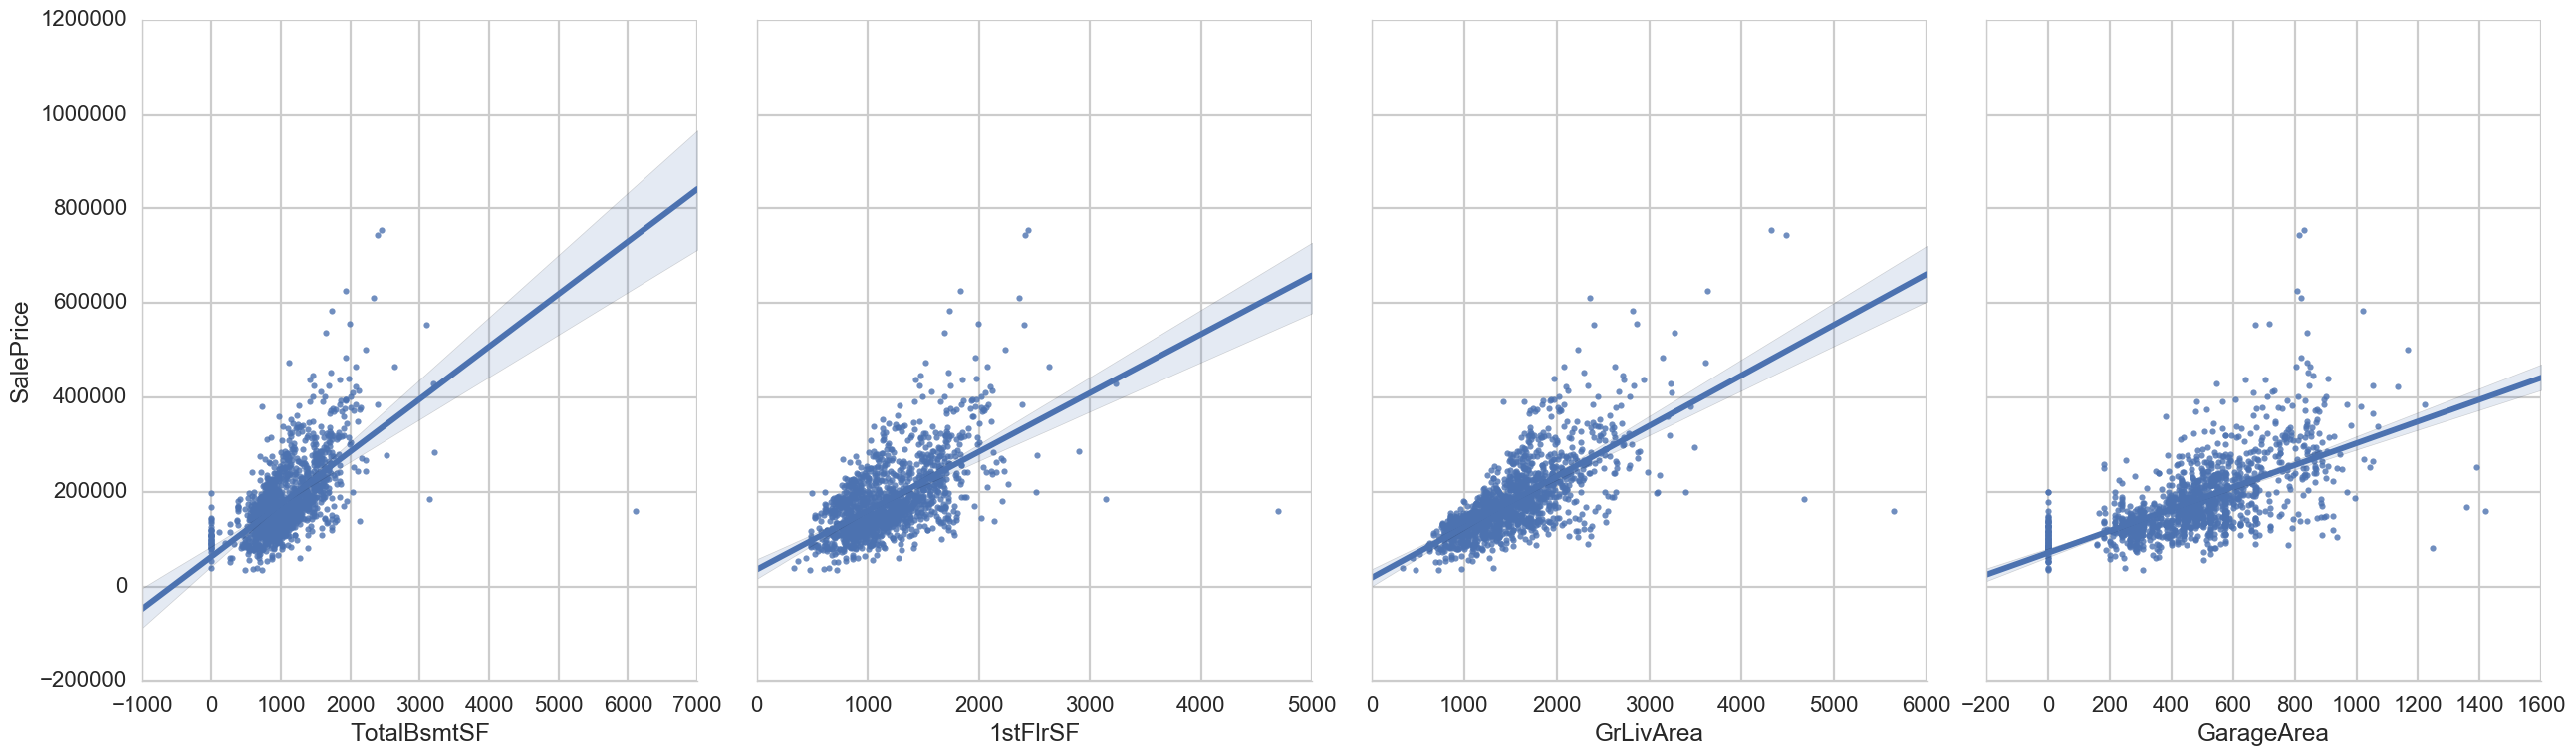

In [13]:
# plotting selected variables plt.scatter(dfc['GarageArea'],dfc.SalePrice)
sns.pairplot(dfc, x_vars=["TotalBsmtSF", "1stFlrSF","GrLivArea","GarageArea"], y_vars=["SalePrice"],
             size=8, aspect=.8, kind="reg");

### Summary 

We used pearson approach in order to find which variables are correlated the most to Saleprice(target var)
However this method measures the influence of a variable on a target only when there is a linear relationship between the vars, for instance: $$X=kS$$ otherwise it's not working.
Example $x$ and $x^2$

## linear models and regularization

### L1 regularization / Lasso

In [35]:
from sklearn import preprocessing
y=preprocessing.scale(np.log1p(dfc.SalePrice.values))
X=preprocessing.scale(np.log1p(dfc[["TotalBsmtSF", "1stFlrSF","GrLivArea","GarageArea"]].values.reshape(y.shape[0],4)))
XTotalBsmtSF=dfc[["TotalBsmtSF"]].values.reshape(y.shape[0],1)
X1stFlrSF=dfc[["1stFlrSF"]].values.reshape(y.shape[0],1)
XGrLivArea=dfc[["GrLivArea"]].values.reshape(y.shape[0],1)
XGarageArea=dfc[["GarageArea"]].values.reshape(y.shape[0],1)


print X,y


[[ 0.00251287 -0.80364504  0.52919393  0.34369294]
 [ 0.34111448  0.41847858 -0.38196548  0.22359256]
 [ 0.06539671 -0.57667677  0.65963119  0.41499667]
 ..., 
 [ 0.26155366  0.22820766  1.47010236 -0.1888922 ]
 [ 0.20363749 -0.07772073 -0.8545358  -0.22229787]
 [ 0.33695677  0.40347203 -0.39625742 -0.12658863]] [ 0.56006699  0.21276333  0.73404616 ...,  1.17470887 -0.39965728
 -0.30669507]


In [25]:
# apply pca on X 
from sklearn.decomposition import PCA
X_scaled = preprocessing.scale(X)
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X_scaled)
print Xpca.shape, pca.explained_variance_ratio_.sum()

(1460, 2) 0.823568304217


/Users/mac/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [40]:
gsbestLasso=cv_optimize(Lasso(normalize=True),{"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}, X, y, n_jobs=1, n_folds=5, score_func=None)

BEST {'alpha': 5e-05} 0.660686438271 [mean: 0.66068, std: 0.03426, params: {'alpha': 1e-08}, mean: 0.66068, std: 0.03425, params: {'alpha': 1e-06}, mean: 0.66068, std: 0.03422, params: {'alpha': 1e-05}, mean: 0.66069, std: 0.03409, params: {'alpha': 5e-05}, mean: 0.66068, std: 0.03393, params: {'alpha': 0.0001}, mean: 0.66014, std: 0.03269, params: {'alpha': 0.0005}, mean: 0.65833, std: 0.03126, params: {'alpha': 0.001}, mean: 0.44069, std: 0.01210, params: {'alpha': 0.01}, mean: -0.00347, std: 0.00513, params: {'alpha': 0.1}, mean: -0.00347, std: 0.00513, params: {'alpha': 1.0}]


In [42]:
#print gsbestLasso.best_estimator_.coef_
#print gsbestLasso.best_params_
print gsbestLasso.best_score_
#print gsbestLasso.grid_scores_
bestest=gsbestLasso.best_estimator_

0.660686438271


In [38]:
def compareR(X,y,bestest):
    dfr=pd.DataFrame()
    dfr['predict']=bestest.predict(X)
    dfr['true']=y
    dfr['difference']=np.abs(bestest.predict(X)-y)
    return dfr
compareR(Xpca,y,gsbestLasso).head()
    


,predict,true,difference
0,0.085138,0.560067,0.474929
1,-0.097417,0.212763,0.310180
2,0.283443,0.734046,0.450603
3,0.271975,-0.437383,0.709358
4,1.106347,1.014651,0.091695


### L2 regularization / Ridge regression

In [43]:
gsbestRidge=cv_optimize(Ridge(normalize=True),{"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}, X, y, n_jobs=1, n_folds=5, score_func=None)

BEST {'alpha': 0.01} 0.660732163823 [mean: 0.66068, std: 0.03426, params: {'alpha': 1e-08}, mean: 0.66068, std: 0.03426, params: {'alpha': 1e-06}, mean: 0.66068, std: 0.03426, params: {'alpha': 1e-05}, mean: 0.66068, std: 0.03425, params: {'alpha': 5e-05}, mean: 0.66068, std: 0.03425, params: {'alpha': 0.0001}, mean: 0.66069, std: 0.03422, params: {'alpha': 0.0005}, mean: 0.66069, std: 0.03419, params: {'alpha': 0.001}, mean: 0.66073, std: 0.03364, params: {'alpha': 0.01}, mean: 0.65906, std: 0.02889, params: {'alpha': 0.1}, mean: 0.57745, std: 0.01375, params: {'alpha': 1.0}]


In [44]:
#print gsbestRidge.best_estimator_.coef_
#print gsbestRidge.best_params_
print gsbestRidge.best_score_
#print gsbestRidge.grid_scores_
bestRidge=gsbestRidge.best_estimator_


0.660732163823


In [45]:
compareR(X,y,bestRidge).head()

,predict,true,difference
0,0.162149,0.560067,0.397918
1,0.002139,0.212763,0.210625
2,0.304047,0.734046,0.429999
3,0.254038,-0.437383,0.691421
4,0.850261,1.014651,0.164390


## Individual feature score better than joined

In [32]:
def score4feature(X,y,features,nbrfeature):
    X=dfc[features].values.reshape(y.shape[0],nbrfeature)
    y=dfc.SalePrice.values
    choosenModel1=cv_optimize(Lasso(normalize=True)
                                ,{"alpha": [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}, 
                                Xpca, y, n_jobs=1, n_folds=5, score_func=None)
    print choosenModel1.best_score_
        
    choosenModel2=cv_optimize(Ridge(normalize=True),{"alpha": [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
                                Xpca, y, n_jobs=1, n_folds=5, score_func=None)
        
    print choosenModel2.best_score_
        
        
    return 'done'


In [46]:
#useful corr variables:
#TotalBsmtSF 0.634153297828
#1stFlrSF  0.634153297828
#GrLivArea 0.634153297828

#GarageArea 0.634153297828
score4feature(X,y,['GrLivArea'],1)

BEST {'alpha': 10} 0.634172812765 [mean: 0.63415, std: 0.09369, params: {'alpha': 0.05}, mean: 0.63415, std: 0.09369, params: {'alpha': 0.1}, mean: 0.63415, std: 0.09366, params: {'alpha': 0.3}, mean: 0.63415, std: 0.09358, params: {'alpha': 1}, mean: 0.63416, std: 0.09336, params: {'alpha': 3}, mean: 0.63417, std: 0.09314, params: {'alpha': 5}, mean: 0.63417, std: 0.09258, params: {'alpha': 10}, mean: 0.63416, std: 0.09202, params: {'alpha': 15}, mean: 0.63400, std: 0.09035, params: {'alpha': 30}, mean: 0.63352, std: 0.08813, params: {'alpha': 50}, mean: 0.63250, std: 0.08539, params: {'alpha': 75}]
0.634172812765
BEST {'alpha': 0.05} 0.633578469888 [mean: 0.63358, std: 0.08459, params: {'alpha': 0.05}, mean: 0.63047, std: 0.07685, params: {'alpha': 0.1}, mean: 0.60357, std: 0.05555, params: {'alpha': 0.3}, mean: 0.47931, std: 0.03022, params: {'alpha': 1}, mean: 0.27848, std: 0.01848, params: {'alpha': 3}, mean: 0.19325, std: 0.01456, params: {'alpha': 5}, mean: 0.10783, std: 0.01064

'done'

(array([ 107.,  554.,  535.,  189.,   57.,   12.,    2.,    2.,    1.,    1.]),
 array([  334. ,   864.8,  1395.6,  1926.4,  2457.2,  2988. ,  3518.8,
         4049.6,  4580.4,  5111.2,  5642. ]),
 <a list of 10 Patch objects>)

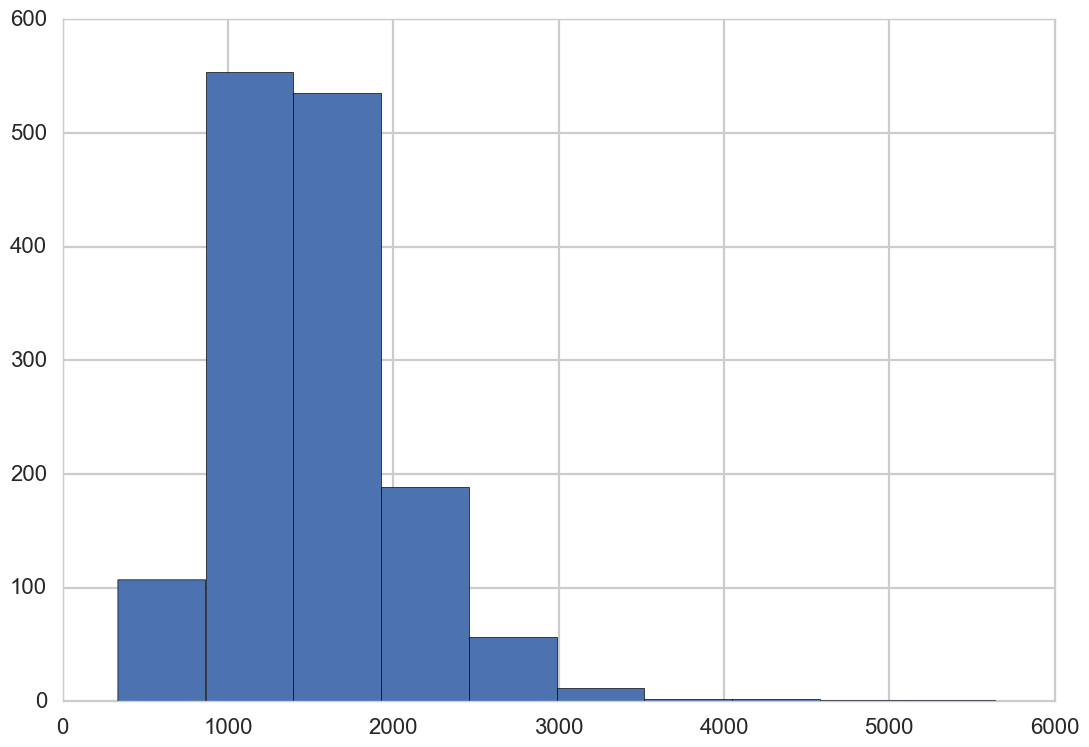

In [51]:
plt.hist(dfc.GrLivArea)

## kaggle model 

In [52]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [55]:
dfc=df.select_dtypes(exclude=['O'])
dfc.columns

Index([u'Id', u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'MoSold', u'YrSold', u'SalePrice'],
      dtype='object')

In [85]:
dfc.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,12.247699
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,12.109016
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,12.317171
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,11.849405
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,12.429220


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a92b750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a9484d0>]], dtype=object)

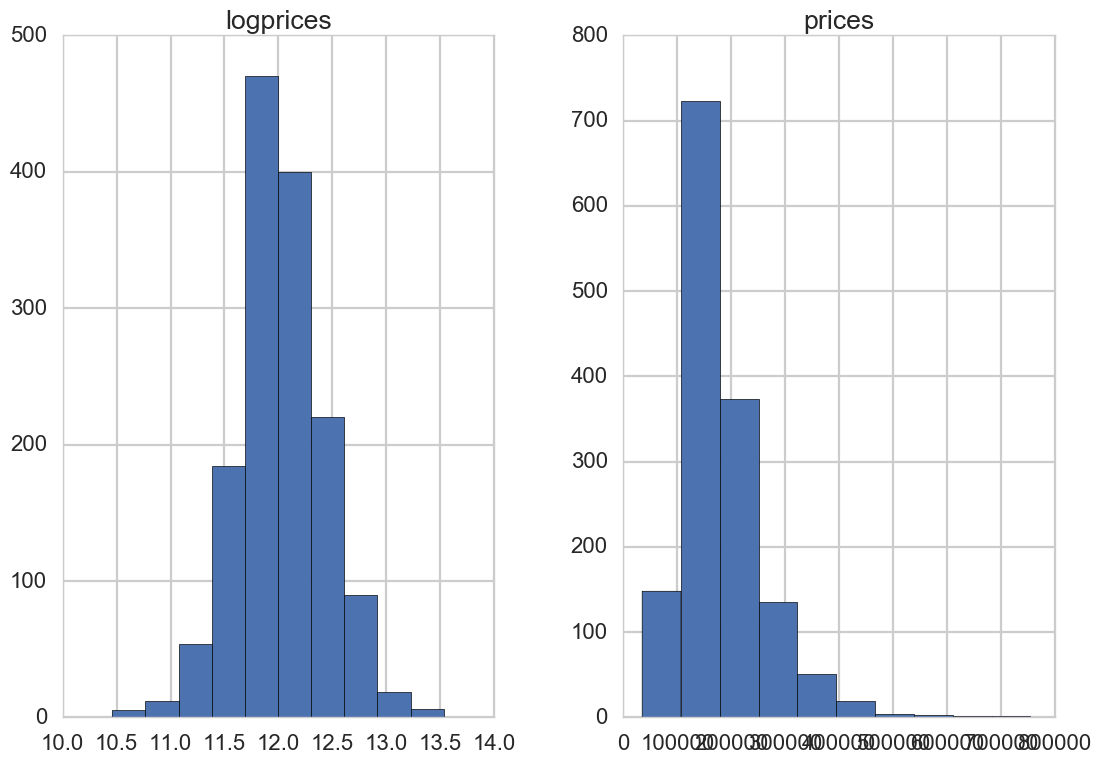

In [60]:
# skew data 
prices=pd.DataFrame({"prices":dfc.SalePrice.values,"logprices":np.log1p(dfc.SalePrice.values)})
prices.hist()

In [61]:
dfc.SalePrice=np.log1p(dfc.SalePrice)

/Users/mac/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [76]:
skewed_feats = dfc.apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [77]:
skewed_feats

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF',
       u'LowQualFinSF', u'GrLivArea', u'BsmtHalfBath', u'KitchenAbvGr',
       u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch',
       u'ScreenPorch', u'PoolArea', u'MiscVal'],
      dtype='object')

In [78]:
dfc[skewed_feats]=np.log1p(dfc[skewed_feats])

/Users/mac/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [86]:
dfc=pd.get_dummies(dfc)

In [87]:
dfc.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,12.247699
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,12.109016
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,12.317171
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,11.849405
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,12.429220


In [89]:
dfc=dfc.fillna(dfc.mean())

In [98]:
dfc.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,12.247699
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,12.109016
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,12.317171
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,11.849405
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,12.429220


In [111]:
Xk=dfc.drop(['SalePrice'],axis=1)

yk=dfc.SalePrice
Xk.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,548,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,460,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,608,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,642,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,836,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008


In [118]:
gsbestRidge=cv_optimize(Lasso(normalize=True),{"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}, Xk, yk, n_jobs=1, n_folds=5, score_func="mean_squared_error")

BEST {'alpha': 5e-05} -0.0197009557546 [mean: -0.01982, std: 0.00428, params: {'alpha': 1e-08}, mean: -0.01981, std: 0.00429, params: {'alpha': 1e-06}, mean: -0.01974, std: 0.00432, params: {'alpha': 1e-05}, mean: -0.01970, std: 0.00425, params: {'alpha': 5e-05}, mean: -0.01973, std: 0.00408, params: {'alpha': 0.0001}, mean: -0.02143, std: 0.00356, params: {'alpha': 0.0005}, mean: -0.02585, std: 0.00317, params: {'alpha': 0.001}, mean: -0.15963, std: 0.01287, params: {'alpha': 0.01}, mean: -0.15963, std: 0.01287, params: {'alpha': 0.1}, mean: -0.15963, std: 0.01287, params: {'alpha': 1.0}]


In [119]:
#print gsbestRidge.best_estimator_.coef_
#print gsbestRidge.best_params_
print gsbestRidge.best_score_
#print gsbestRidge.grid_scores_
bestRidge=gsbestRidge.best_estimator_



-0.0197009557546


In [117]:
compareR(Xk,yk,bestRidge).head()

,predict,true,difference
0,12.269573,12.247699,0.021874
1,12.191603,12.109016,0.082587
2,12.314321,12.317171,0.002850
3,12.068769,11.849405,0.219365
4,12.602902,12.429220,0.173681


In [134]:
len(Xk.columns)

37